In [1]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana as pdn
import pickle as pkl
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories
for d in ["data", "logs", "models", "networks"]:
    if not os.path.isdir(d):
        os.mkdir(d)

## Trips

In [9]:
# Bring the trips
trips = pd.read_csv(f"data/trips2.csv")
trips = trips[trips['Mun_Ori'] != trips['Mun_Des']]
trips = trips[trips['Act_Des'].isin(['Trabajo habitual', 'Asuntos trabajo'])]

array(['Asuntos trabajo', 'Gestiones personales',
       'Ocio, cultura, deporte', 'Residencia Habitual',
       'Trabajo habitual', 'Otra vivienda', 'Médico / Hospital',
       'Acompañamiento de ayuda, cuidado', 'Centro estudios',
       'Compras personales', 'Compras doméstico-familiares',
       'Otras actividades', 'Gestiones doméstico-familiares'],
      dtype=object)

In [4]:
# Changes primary modes to a different model: auto or green_modes

trips = trips[trips['Modo'] != 'Otros']

# 5 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "Autobus"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "Autobus"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "Autobus"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "Tren"
# trips.loc[trips.Modo=="RENFE","Modo"] = "Tren"

# 2 MODOS, coche y green

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "Green"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "Green"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "Green"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "Green"
# trips.loc[trips.Modo=="RENFE","Modo"] = "Green"
# trips.loc[trips.Modo=="Andando","Modo"] = "Green"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Green"

# 2 MODOS, TP y coche

trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús urbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "TP"
trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "TP"
trips.loc[trips.Modo=="RENFE","Modo"] = "TP"
trips = trips[trips['Modo'] != 'Andando']
trips = trips[trips['Modo'] != 'Bicicleta']

# 3 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "PT"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "PT"
# trips.loc[trips.Modo=="RENFE","Modo"] = "PT"
# trips.loc[trips.Modo=="Andando","Modo"] = "Active modes"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Active modes"

# 4 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "PT"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "PT"
# trips.loc[trips.Modo=="RENFE","Modo"] = "PT"
# trips.loc[trips.Modo=="Andando","Modo"] = "Andando"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Bicicleta"

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.Modo==label].shape[0]:,}" for label in trips.Modo.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Coche: 2,071
TP: 411
Total: 2,482


In [5]:
# Asignar numero a Municipio, para no tener problemas en el encoding. Hay pueblos de test que igual no hay en train entonces no lo puede codificar.

pueblos = pd.read_excel(f"data/pueblos_gipuzkoa.xlsx")
eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
       'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
       'Densidad (hab./kmÂ²)', 'Incluido']
pueblos = pueblos.drop(columns=eliminar)

trips = pd.merge(trips, pueblos, left_on='Municipio', right_on='Town')
trips = trips.drop(columns=['Municipio', 'Town'])
trips.rename(columns={'Código': 'Municipio'}, inplace=True)


# Expand the Data

In [124]:
# Expandir los trips, hacer que cada trayecto sea una fila

# TRAIN

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips_train.iterrows():
    valores_columnas = row[trips_train.columns]
    repeticiones = row['elev']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips_train = pd.DataFrame(nuevas_filas, columns=trips_train.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips_train = trips_train.drop(columns=["elev"])

# Mezclo las filas de manera aleatoria
trips_train = trips_train.sample(frac=1).reset_index(drop=True)

#Expandir los trips, hacer que cada trayecto sea una fila

# TEST

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips_test.iterrows():
    valores_columnas = row[trips_test.columns]
    repeticiones = row['elev']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips_test = pd.DataFrame(nuevas_filas, columns=trips_test.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips_test = trips_test.drop(columns=["elev"])

# Mezclo las filas de manera aleatoria
trips_test = trips_test.sample(frac=1).reset_index(drop=True)

# Change modes of transportation

In [7]:
# Reducir el numero de trips en coche a la suma del resto de modos.

# Numero de green trips
condicion = trips['Modo'] != 'Coche'
green_trips = condicion.sum()

condicion = trips['Modo'] == 'Coche'
coche_trips = condicion.sum()
eliminar=coche_trips-green_trips

#eliminar=len(trips['MODO_INFORME']=='Coche')-green_trips

# Escoger aleatoriamente ese numero de trips de todos los del coche

# Filtrar las filas que cumplen con el modo de transporte "coche"
coche_rows = trips[trips['Modo'] == 'Coche']

# Seleccionar aleatoriamente X filas del conjunto de filas "coche_rows"
muestras_aleatorias = coche_rows.sample(n=eliminar)

# Eliminar las filas que no fueron seleccionadas aleatoriamente
trips = trips[~trips.index.isin(muestras_aleatorias.index)]

trips=trips.reset_index(drop=True)

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.Modo==label].shape[0]:,}" for label in trips.Modo.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

TP: 337
Coche: 337
Total: 674


In [8]:
# Filtrar
trips = trips.drop(columns=['Unnamed: 0'])
trips = trips.reset_index(drop=True)

# Asignar Lat y Long origen y destino

Bring the buildings

In [9]:
# Leer el archivo Shapefile
gdf = gpd.read_file(f"data/ERAIKINAK_EDIFICIOS/buildings.shp")

# Pasar las geometrias de los edificios de sistema UTM a sistema decimal de coordenadas
crs_objetivo = 'EPSG:4326'  # WGS84
gdf = gdf.to_crs(crs_objetivo)

# Crear una columna que contiene el centroide del edificio, para obtener un punto
gdf['Centroide'] = gdf['geometry'].centroid
gdf.columns

C:\Users\iazka\AppData\Local\Temp\ipykernel_44964\1237833868.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['Centroide'] = gdf['geometry'].centroid


Index(['Town', 'Edificabil', 'Solar', 'Vivienda', 'Trastero', 'Garaje Cer',
       'Agropecuar', 'Local Come', 'Industrial', 'Almacen', 'Deportivo',
       'Cultural', 'Educativo', 'Oficina', 'Hosteleria', 'Obras Urba',
       'Altura men', 'Terraza', 'Accesos y', 'Jardin', 'Sanidad', 'Deposito',
       'Duplex', 'Plaza Park', 'Religioso', 'Espectacul', 'geometry',
       'Centroide'],
      dtype='object')

In [10]:
asignaciones = {
    'Otra vivienda': ['Vivienda', 'Duplex'],
    'Centro estudios': ['Educativo'],
    'Compras doméstico-familiares': ['Local Come'],
    'Asuntos trabajo': ['Oficina'],
    'Trabajo habitual': ['Oficina'],
    'Ocio, cultura, deporte': ['Deportivo', 'Cultural', 'Hosteleria', 'Terraza', 'Jardin', 'Religioso', 'Espectacul'],
    'Acompañamiento de ayuda, cuidado': ['Local Come'],
    'Residencia Habitual': ['Vivienda', 'Duplex'],
    'Médico / Hospital': ['Sanidad'],
    'Gestiones personales': ['Local Come'],
    'Compras personales': ['Local Come'],
    'Otras actividades': ['Local Come'],
    'Gestiones doméstico-familiares': ['Local Come'],

}

# Encontrar la longitud máxima de todas las listas
max_length = max(len(lista) for lista in asignaciones.values())

# Rellenar las listas con valores NaN para que tengan la misma longitud
for columna in asignaciones:
    asignaciones[columna] += [np.nan] * (max_length - len(asignaciones[columna]))

# Crear el DataFrame a partir del diccionario
asignaciones = pd.DataFrame(asignaciones)

In [11]:
# Función para obtener la lista de una columna específica
def obtener_lista_por_columna(df, columna):
    if columna in df.columns:
        l = df[columna].tolist()
        l = [x for x in l if isinstance(x, str)]
        return l
    else:
        return []

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_origen(row):
    matching_rows = gdf[gdf['Town'] == row['Mun_Ori']] # Lista con todos las RC de ese pueblo
    matching_usos = obtener_lista_por_columna(asignaciones, row['Act_Ori']) # Lista con los posibles usos de esa actividad
    matching_rows = matching_rows[(matching_rows[matching_usos] != 0).any(axis=1)] # De las RC del pueblo, coge solo las que no tienen nulo el m2, mínimo alguno de los usos de suelo asignado a esa actividad origen. Esto es, si hay alguna RC que no tiene ningún uso de suelo de interés para esa actividad, se elimina.

    # Genero una matriz auxiliar quitando Town, geometry y Centroide para hacer los calculos
    auxiliar = matching_rows.drop(columns=['Town', 'geometry', 'Centroide'])
    # Hasta este punto, tengo un gdf con las RC de pueblo adecuado y con todas las RC que hacen match con esa actividad, esto es, no hay ninguna fila que tenga todos los m2 nulos.
    # El próximo paso es asignar una fila (RC), y para ello escojo por probabilidad una ubicación exacta de la matriz (tanto RC como uso de suelo) y selecciono esa fila (RC) para pasarle

    if not matching_rows.empty:
        probabilidades = auxiliar.values / auxiliar.values.sum() # Normalizar los valores para representar probabilidades
        # Generar números aleatorios para seleccionar fila y columna
        fila_seleccionada = random.choices(range(auxiliar.shape[0]), weights=probabilidades.sum(axis=1))[0]
        columna_seleccionada = random.choices(range(auxiliar.shape[1]), weights=probabilidades[fila_seleccionada])[0]
        valor_seleccionado = auxiliar.iloc[fila_seleccionada, columna_seleccionada]         # Obtener el valor seleccionado, fila y columna
        fila = matching_rows.index[fila_seleccionada] # Devolver la fila, la columna y el valor seleccionado
        return gdf.loc[fila, 'Centroide']
    else:
        return None

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_destino(row):
    matching_rows = gdf[gdf['Town'] == row['Mun_Des']] # Lista con todos las RC de ese pueblo
    matching_usos = obtener_lista_por_columna(asignaciones, row['Act_Des']) # Lista con los posibles usos de esa actividad
    matching_rows = matching_rows[(matching_rows[matching_usos] != 0).any(axis=1)] # De las RC del pueblo, coge solo las que no tienen nulo el m2, mínimo alguno de los usos de suelo asignado a esa actividad origen. Esto es, si hay alguna RC que no tiene ningún uso de suelo de interés para esa actividad, se elimina.

    # Genero una matriz auxiliar quitando Town, geometry y Centroide para hacer los calculos
    auxiliar = matching_rows.drop(columns=['Town', 'geometry', 'Centroide'])
    # Hasta este punto, tengo un gdf con las RC de pueblo adecuado y con todas las RC que hacen match con esa actividad, esto es, no hay ninguna fila que tenga todos los m2 nulos.
    # El próximo paso es asignar una fila (RC), y para ello escojo por probabilidad una ubicación exacta de la matriz (tanto RC como uso de suelo) y selecciono esa fila (RC) para pasarle

    if not matching_rows.empty:
        probabilidades = auxiliar.values / auxiliar.values.sum() # Normalizar los valores para representar probabilidades
        # Generar números aleatorios para seleccionar fila y columna
        fila_seleccionada = random.choices(range(auxiliar.shape[0]), weights=probabilidades.sum(axis=1))[0]
        columna_seleccionada = random.choices(range(auxiliar.shape[1]), weights=probabilidades[fila_seleccionada])[0]
        valor_seleccionado = auxiliar.iloc[fila_seleccionada, columna_seleccionada]         # Obtener el valor seleccionado, fila y columna
        fila = matching_rows.index[fila_seleccionada] # Devolver la fila, la columna y el valor seleccionado
        return gdf.loc[fila, 'Centroide']
    else:
        return None


# Aplicar la función a trips para crear la columna Edif_ORIGEN y Edif_DESTINO

# TRAIN

trips['Edif_Ori'] = trips.apply(asignar_coord_origen, axis=1)
trips['Edif_Des'] = trips.apply(asignar_coord_destino, axis=1)

In [12]:
# Save

trips.to_csv(f"data/Gipuzkoa_MT2_not_extended_train.csv")

In [13]:
# Pasa de un punto en formato WKT a dos columnas con LONG y LAT

from shapely import wkt
from shapely.geometry import Point

def extraer_longitud(punto):
    return punto.x

def extraer_latitud(punto):
    return punto.y

# from shapely import wkt
# from shapely.geometry import Point

# def extraer_longitud(punto_wkt):
#     punto = wkt.loads(punto_wkt)
#     return punto.x

# def extraer_latitud(punto_wkt):
#     punto = wkt.loads(punto_wkt)
#     return punto.y

# TRAIN

trips['O_long'] = trips['Edif_Ori'].apply(extraer_longitud)
trips['O_lat'] = trips['Edif_Ori'].apply(extraer_latitud)
trips['D_long'] = trips['Edif_Des'].apply(extraer_longitud)
trips['D_lat'] = trips['Edif_Des'].apply(extraer_latitud)

trips = trips.drop(columns=["Edif_Ori","Edif_Des"])
trips = trips.reset_index(drop=True)

In [ ]:
# Codificar la hora manualmente

trips['Hora_Ini'] = pd.to_datetime(trips['Hora_Ini'], format='%H:%M')

# Calcula la diferencia en minutos desde "00:00" y divídela por 5
trips['Hora_Ini'] = ((trips['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1

In [15]:
# Save
trips.to_csv(f"data/Gipuzkoa_MT2_not_extended_new.csv")

In [42]:
# Bring
trips = pd.read_csv(f"data/Gipuzkoa_MT2_not_extended_new.csv",index_col=0)

# Add Travel Time

In [16]:
# Crea un diccionario, donde los valores son None y las claves son esas cuatro

networks = dict.fromkeys({
 "walk",
 "drive",
})

# Asigna al valor correspondiente en el diccionario networks un objeto de red creado mediante el método from_hdf5() de la clase Network del módulo pdn.network. 
# Los creados con los codigos anteriores

for k in networks:
    print(k)
    networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')


# TRANSIT

transit = dict.fromkeys({
 "transit_0001", "transit_0102", "transit_0203", "transit_0304", "transit_0405", "transit_0506", "transit_0607", "transit_0708", "transit_0809", "transit_0910", "transit_1011", "transit_1112", "transit_1213", "transit_1314", "transit_1415", "transit_1516", "transit_1617", "transit_1718", "transit_1819", "transit_1920", "transit_2021", "transit_2122", "transit_2223", "transit_2324",
})

for k in transit:
    print(k)
    transit[k] = pdn.network.Network.from_hdf5(f'transit_24/transit_{k}.h5')

# TRAIN

train = dict.fromkeys({
 "train_0001", "train_0102", "train_0203", "train_0304", "train_0405", "train_0506", "train_0607", "train_0708", "train_0809", "train_0910", "train_1011", "train_1112", "train_1213", "train_1314", "train_1415", "train_1516", "train_1617", "train_1718", "train_1819", "train_1920", "train_2021", "train_2122", "train_2223", "train_2324",
})

for k in train:
    print(k)
    train[k] = pdn.network.Network.from_hdf5(f'train_24/train_{k}.h5')

walk
drive
transit
train


In [44]:
# Asignar tt a cada modo de transporte para cada trip

# Para cada trip, asigna la distancia mas corta que se puede hacer con Network (walk, drive, transit) con shortest_path_lengths
# Coge lat,long de origen y destino de cada trip. A ese origen y destino le asigna el nodo del Network correspondiente más cercano con get_node_ids
# Le pasa esos nodos del Network correspondiente a shortest_path_lengths, y este calcula la distancia entre esos nodos

for k in networks:
    if k != 'drive':
        trips_train[f"{k}_tt"] = networks[k].shortest_path_lengths(
            networks[k].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks[k].get_node_ids(trips_train.D_long,trips_train.D_lat)
            )

trips_train["walk_tt"] = trips_train["walk_tt"] / 80.46 # Pasar de distancia (m) a minutos con un ritmo de 3 mp/h = 80.46 m/min.

trips_train["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks['drive'].get_node_ids(trips_train.D_long,trips_train.D_lat),
            imp_name='drive_time_s'
            )

trips_train["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks['drive'].get_node_ids(trips_train.D_long,trips_train.D_lat),
            imp_name='distance'
            )

trips_train["drive_tt"] = trips_train["drive_tt"] / 60 # Para pasar a minutos
trips_train["bike_tt"] =  networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks['drive'].get_node_ids(trips_train.D_long,trips_train.D_lat),
            imp_name='distance'
            )
trips_train["bike_tt"] = trips_train["bike_tt"] * 60 / (1000*13.07)  # 13.07 km/h = 13.07*1000/60 m/min

# trips_train['pt_tt'] = trips_train[['train_tt', 'transit_tt']].min(axis=1)
# trips_train = trips_train.drop(columns=['train_tt', 'transit_tt'])

# Eliminar andando y bike

trips_train = trips_train.drop(columns=['walk_tt', 'bike_tt'])

# Añado TRANSIT

# Hacer que los que estan a horas que no hay autobuses, se emplea la red andando

condition = (25 <= trips['Hora_Ini']) & (trips['Hora_Ini'] <= 48)
trips.loc[condition, 'transit_tt'] = networks['walk'].shortest_path_lengths(
    networks['walk'].get_node_ids(trips.loc[condition, 'O_long'], trips.loc[condition, 'O_lat']),
    networks['walk'].get_node_ids(trips.loc[condition, 'D_long'], trips.loc[condition, 'D_lat']),
)

# Add a column that represents the corresponding network

network_mapping = {
    1 <= trips['Hora_Ini'] <= 12: 'transit_0001',
    13 <= trips['Hora_Ini'] <= 24: 'transit_0102',
    # 25 <= trips['Hora_Ini'] <= 36: 'transit_0203',
    # 37 <= trips['Hora_Ini'] <= 48: 'transit_0304',
    49 <= trips['Hora_Ini'] <= 60: 'transit_0405',
    61 <= trips['Hora_Ini'] <= 72: 'transit_0506',
    73 <= trips['Hora_Ini'] <= 84: 'transit_0607',
    85 <= trips['Hora_Ini'] <= 96: 'transit_0708',
    97 <= trips['Hora_Ini'] <= 108: 'transit_0809',
    109 <= trips['Hora_Ini'] <= 120: 'transit_0910',
    121 <= trips['Hora_Ini'] <= 132: 'transit_1011',
    133 <= trips['Hora_Ini'] <= 144: 'transit_1112',
    145 <= trips['Hora_Ini'] <= 156: 'transit_1213',
    157 <= trips['Hora_Ini'] <= 168: 'transit_1314',
    169 <= trips['Hora_Ini'] <= 180: 'transit_1415',
    181 <= trips['Hora_Ini'] <= 192: 'transit_1516',
    193 <= trips['Hora_Ini'] <= 204: 'transit_1617',
    205 <= trips['Hora_Ini'] <= 216: 'transit_1718',
    217 <= trips['Hora_Ini'] <= 228: 'transit_1819',
    229 <= trips['Hora_Ini'] <= 240: 'transit_1920',
    241 <= trips['Hora_Ini'] <= 252: 'transit_2021',
    253 <= trips['Hora_Ini'] <= 264: 'transit_2122',
    265 <= trips['Hora_Ini'] <= 276: 'transit_2223',
    277 <= trips['Hora_Ini'] <= 288: 'transit_2324',
}

if any(network_mapping.keys()):
    selected_network = network_mapping[True]
    trips['transit_network_name'] = selected_network

# Asignar el tiempo

def calculate_shortest_path_transit(row):
    network_name = row['transit_network_column']
    return networks[network_name].shortest_path_lengths(
        networks[network_name].get_node_ids(row['O_long'], row['O_lat']),
        networks[network_name].get_node_ids(row['D_long'], row['D_lat'])
    )

trips["transit_tt"] = trips.apply(calculate_shortest_path_transit, axis=1)
trips = trips.drop(columns='transit_network_name')

# Añado TRAIN

# Hacer que los que estan a horas que no hay autobuses, se emplea la red andando

condition = (1 <= trips['Hora_Ini']) & (trips['Hora_Ini'] <= 60)
trips.loc[condition, 'transit_tt'] = networks['walk'].shortest_path_lengths(
    networks['walk'].get_node_ids(trips.loc[condition, 'O_long'], trips.loc[condition, 'O_lat']),
    networks['walk'].get_node_ids(trips.loc[condition, 'D_long'], trips.loc[condition, 'D_lat']),
)

# Add a column that represents the corresponding network

network_mapping = {
    # 1 <= trips['Hora_Ini'] <= 12: 'train_0001',
    # 13 <= trips['Hora_Ini'] <= 24: 'train_0102',
    # 25 <= trips['Hora_Ini'] <= 36: 'train_0203',
    # 37 <= trips['Hora_Ini'] <= 48: 'train_0304',
    # 49 <= trips['Hora_Ini'] <= 60: 'train_0405',
    61 <= trips['Hora_Ini'] <= 72: 'train_0506',
    73 <= trips['Hora_Ini'] <= 84: 'train_0607',
    85 <= trips['Hora_Ini'] <= 96: 'train_0708',
    97 <= trips['Hora_Ini'] <= 108: 'train_0809',
    109 <= trips['Hora_Ini'] <= 120: 'train_0910',
    121 <= trips['Hora_Ini'] <= 132: 'train_1011',
    133 <= trips['Hora_Ini'] <= 144: 'train_1112',
    145 <= trips['Hora_Ini'] <= 156: 'train_1213',
    157 <= trips['Hora_Ini'] <= 168: 'train_1314',
    169 <= trips['Hora_Ini'] <= 180: 'train_1415',
    181 <= trips['Hora_Ini'] <= 192: 'train_1516',
    193 <= trips['Hora_Ini'] <= 204: 'train_1617',
    205 <= trips['Hora_Ini'] <= 216: 'train_1718',
    217 <= trips['Hora_Ini'] <= 228: 'train_1819',
    229 <= trips['Hora_Ini'] <= 240: 'train_1920',
    241 <= trips['Hora_Ini'] <= 252: 'train_2021',
    253 <= trips['Hora_Ini'] <= 264: 'train_2122',
    265 <= trips['Hora_Ini'] <= 276: 'train_2223',
    277 <= trips['Hora_Ini'] <= 288: 'train_2324',
}

if any(network_mapping.keys()):
    selected_network = network_mapping[True]
    trips['train_network_name'] = selected_network

# Asignar el tiempo

def calculate_shortest_path_train(row):
    network_name = row['train_network_column']  # Reemplaza 'network_column' con el nombre de tu columna
    return networks[network_name].shortest_path_lengths(
        networks[network_name].get_node_ids(row['O_long'], row['O_lat']),
        networks[network_name].get_node_ids(row['D_long'], row['D_lat'])
    )

trips["train_tt"] = trips.apply(calculate_shortest_path_train, axis=1)
trips = trips.drop(columns='train_network_name')

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(450838176, 2150637753), (9474344930, 5320194863), (10988321082, 5320194882), (2095754976, 623872234), (8235607129, 10059544708), (10992238018, 8235607129), (8235607149, 10583742549), (7571875934, 5320194863), (623872234, 3421394595)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(86193, 96231), (100879, 86193), (86212, 3058)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                

Prov_Ori  Prov_Des             Com_Ori             Com_Des  \
0          20        20        Donostialdea  Urola Kosta          
1          20        20  Urola Kosta         Urola Kosta          
2          20        20         Debabarrena         Debabarrena   
3          20        20             Bidasoa        Donostialdea   
4          20        20          Debagoiena             Bidasoa   
..        ...       ...                 ...                 ...   
669        20        20  Urola Kosta                Debabarrena   
670        20        20        Donostialdea         Debabarrena   
671        20        20        Donostialdea        Donostialdea   
672        20        20          Tolosaldea        Donostialdea   
673        20        20        Donostialdea        Donostialdea   

                    Mun_Ori                 Mun_Des              Act_Ori  \
0    Donostia/San Sebastian                 Zarautz     Trabajo habitual   
1                  Azkoitia                Azpeitia  Residencia Habitual   
2                  Elgoibar                   Eibar     Trabajo habitual   
3                      Irun  Donostia/San Sebastian  Residencia Habitual   
4        Arrasate/Mondragon                    Irun      Asuntos trabajo   
..                      ...                     ...                  ...   
669                  Zumaia                    Deba  Residencia Habitual   
670  Donostia/San Sebastian                   Eibar      Asuntos trabajo   
671              Errenteria  Donostia/San Sebastian  Residencia Habitual   
672                  Tolosa                 Andoain     Trabajo habitual   
673  Donostia/San Sebastian                 Andoain     Trabajo habitual   

                 Act_Des Proposito   Modo  ...     Income  Municipio  \
0    Residencia Habitual   Trabajo     TP  ...  19728.825         79   
1       Trabajo habitual   Trabajo  Coche  ...  25347.460         17   
2    Residencia Habitual   Trabajo     TP  ...  25792.160         30   
3       Trabajo habitual   Trabajo     TP  ...  19568.650         45   
4    Residencia Habitual   Trabajo  Coche  ...  22104.470         45   
..                   ...       ...    ...  ...        ...        ...   
669     Trabajo habitual   Trabajo     TP  ...  20947.300         81   
670  Residencia Habitual   Trabajo     TP  ...  26374.410         30   
671     Trabajo habitual   Trabajo  Coche  ...  21724.535         67   
672  Residencia Habitual   Trabajo  Coche  ...  21917.000          9   
673  Residencia Habitual   Trabajo     TP  ...  21067.000          9   

       O_long      O_lat    D_long      D_lat  transit_tt  train_tt  \
0   -2.004190  43.312481 -2.171735  43.281636      18.736    60.206   
1   -2.306150  43.179993 -2.254275  43.210340      36.371    89.410   
2   -2.395206  43.228177 -2.471055  43.183439      23.579    57.910   
3   -1.822120  43.329714 -1.983174  43.322112      35.055    44.192   
4   -2.509094  43.061919 -1.787255  43.342328     101.653   332.934   
..        ...        ...       ...        ...         ...       ...   
669 -2.259121  43.290125 -2.339013  43.274421      29.332    76.118   
670 -1.982040  43.304951 -2.470999  43.181130      26.528   104.306   
671 -1.901227  43.312396 -1.970826  43.310748      23.142    27.380   
672 -2.068188  43.129382 -2.017410  43.219355      34.019    37.813   
673 -1.978340  43.303672 -2.031904  43.208637      33.808    52.261   

      drive_tt   distance  
0    11.446250  16432.796  
1    12.190950   7184.331  
2     8.829133   9668.731  
3    12.436467  14131.140  
4    53.463683  81284.661  
..         ...        ...  
669   8.787617   9538.713  
670  30.861833  50100.233  
671   6.256200   6826.684  
672  12.368233  12278.695  
673  10.842083  13612.264  

[674 rows x 40 columns]

In [45]:
# Asignar tt a cada modo de transporte para cada trip

# Para cada trip, asigna la distancia mas corta que se puede hacer con Network (walk, drive, transit) con shortest_path_lengths
# Coge lat,long de origen y destino de cada trip. A ese origen y destino le asigna el nodo del Network correspondiente más cercano con get_node_ids
# Le pasa esos nodos del Network correspondiente a shortest_path_lengths, y este calcula la distancia entre esos nodos

for k in networks:
    if k != 'drive':
        trips_test[f"{k}_tt"] = networks[k].shortest_path_lengths(
            networks[k].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks[k].get_node_ids(trips_test.D_long,trips_test.D_lat)
            )

trips_test["walk_tt"] = trips_test["walk_tt"] / 80.46 # Pasar de distancia (m) a minutos con un ritmo de 3 mp/h = 80.46 m/min.

trips_test["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks['drive'].get_node_ids(trips_test.D_long,trips_test.D_lat),
            imp_name='drive_time_s'
            )

trips_test["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks['drive'].get_node_ids(trips_test.D_long,trips_test.D_lat),
            imp_name='distance'
            )

trips_test["drive_tt"] = trips_test["drive_tt"] / 60 # Para pasar a minutos
trips_test["bike_tt"] =  networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks['drive'].get_node_ids(trips_test.D_long,trips_test.D_lat),
            imp_name='distance'
            )
trips_test["bike_tt"] = trips_test["bike_tt"] * 60 / (1000*13.07)  # 13.07 km/h = 13.07*1000/60 m/min

# trips_test['pt_tt'] = trips_test[['train_tt', 'transit_tt']].min(axis=1)
# trips_test = trips_test.drop(columns=['train_tt', 'transit_tt'])

# Eliminar andando y bike

trips_test = trips_test.drop(columns=['walk_tt', 'bike_tt'])
trips_test

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(8235607129, 525257134), (581995285, 2222691332), (8235607129, 316135306), (2682631024, 6543532399), (10308994426, 9261054158), (2085204212, 5320435024)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(86193, 16264), (86193, 2142), (97632, 89302)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(80032, 11663), (80032, 85), (

Prov_Ori  Prov_Des             Com_Ori  \
0          20        20        Donostialdea   
1          20        20        Donostialdea   
2          20        20  Urola Kosta          
3          20        20        Donostialdea   
4          20        20        Donostialdea   
..        ...       ...                 ...   
482        20        20        Donostialdea   
483        20        20        Donostialdea   
484        20        20        Donostialdea   
485        20        20        Donostialdea   
486        20        20        Donostialdea   

                                   Com_Des       Mun_Ori  \
0    Goierri                                     Andoain   
1                       Urola Kosta              Andoain   
2                             Donostialdea       Zarautz   
3                                  Bidasoa       Andoain   
4                             Donostialdea       Andoain   
..                                     ...           ...   
482                           Donostialdea  Lasarte-Oria   
483                           Donostialdea        Pasaia   
484                           Donostialdea  Lasarte-Oria   
485                           Donostialdea  Lasarte-Oria   
486                           Donostialdea       Andoain   

                    Mun_Des              Act_Ori              Act_Des  \
0                   Beasain  Residencia Habitual     Trabajo habitual   
1                   Zarautz  Residencia Habitual     Trabajo habitual   
2                   Andoain     Trabajo habitual  Residencia Habitual   
3                      Irun  Residencia Habitual     Trabajo habitual   
4    Donostia/San Sebastian  Residencia Habitual      Asuntos trabajo   
..                      ...                  ...                  ...   
482                  Pasaia  Residencia Habitual     Trabajo habitual   
483            Lasarte-Oria     Trabajo habitual  Residencia Habitual   
484                  Pasaia  Residencia Habitual     Trabajo habitual   
485                 Andoain  Residencia Habitual     Trabajo habitual   
486            Lasarte-Oria     Trabajo habitual  Residencia Habitual   

    Proposito   Modo  ...     Income  Municipio    O_long      O_lat  \
0     Trabajo     TP  ...  24474.020          9 -2.024691  43.221207   
1     Trabajo  Coche  ...  24629.120          9 -2.018167  43.217201   
2     Trabajo  Coche  ...  24629.120          9 -2.166246  43.281483   
3     Trabajo  Coche  ...  24629.120          9 -2.015358  43.215587   
4     Trabajo  Coche  ...  22419.970          9 -2.024358  43.221716   
..        ...    ...  ...        ...        ...       ...        ...   
482   Trabajo  Coche  ...  23839.560         83 -2.022744  43.270765   
483   Trabajo  Coche  ...  23748.260         83 -1.918149  43.320613   
484   Trabajo  Coche  ...  26115.410         83 -2.021504  43.270064   
485   Trabajo  Coche  ...  21573.085         83 -2.019195  43.265937   
486   Trabajo  Coche  ...  21573.085         83 -2.037332  43.208007   

       D_long      D_lat  transit_tt  train_tt   drive_tt   distance  
0   -2.209558  43.043715      70.316    56.633  20.191683  30088.740  
1   -2.178108  43.276562      52.584    87.782  17.856083  22947.192  
2   -2.024218  43.221135      31.231    76.529  13.514117  20565.224  
3   -1.818712  43.330582      72.729    67.632  16.191333  23934.015  
4   -2.020282  43.301365      35.320    70.070  10.307550  11296.731  
..        ...        ...         ...       ...        ...        ...  
482 -1.935819  43.321109      32.955    44.769   8.868133  10831.338  
483 -2.018403  43.255062      55.581    61.883  11.756683  13051.442  
484 -1.918149  43.320613      34.219    42.727  10.598867  11842.477  
485 -2.000679  43.230545      32.888    59.959   6.245817   5701.572  
486 -2.012993  43.263853      31.067    75.062   7.017833   6974.709  

[487 rows x 40 columns]

# Add travel cost

In [46]:
# Coche, precio por km

fuel_price_11=1.328 #€/litro
fuel_price_16=1.151 #€/litro
fuel_price_21=1.825 #€/litro
consumo_medio=7 #litros/100km
precio_21=(fuel_price_21*consumo_medio/100)/1000
precio_16=(fuel_price_16*consumo_medio/100)/1000
precio_11=(fuel_price_11*consumo_medio/100)/1000

def custom_multiplier(row):
    if row['Año'] == 2021:
        return row['distance'] * precio_21
    elif row['Año'] == 2016:
        return row['distance'] * precio_16
    else:
        return row['distance'] * precio_11

# trips_train['drive_tc'] = trips_train.apply(custom_multiplier, axis=1)
trips_train['drive_tc'] = trips_train['distance']*precio_21
trips_test['drive_tc'] = trips_test['distance']*precio_21

In [47]:
# Transporte publico

#Precios

precios_lurraldebus = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Lurraldebus_precios', usecols=[0, 1])
precios_euskotren = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Euskotren_precios', usecols=[0, 1])
precios_renfe = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Renfe_precios', usecols=[0, 1])

precios_lurraldebus=precios_lurraldebus.dropna()
precios_euskotren=precios_euskotren.dropna()
precios_renfe=precios_renfe.dropna()

# Saltos entre comarcas

saltos_lurraldebus = pd.read_csv(f"data/saltos_lurraldebus.csv")
saltos_euskotren = pd.read_csv(f"data/saltos_euskotren.csv")
saltos_renfe = pd.read_csv(f"data/saltos_renfe.csv")

saltos_lurraldebus=saltos_lurraldebus.merge(precios_lurraldebus, on='Saltos', how='left')
saltos_euskotren=saltos_euskotren.merge(precios_euskotren, on='Saltos', how='left')
saltos_renfe=saltos_renfe.merge(precios_renfe, on='Saltos', how='left')

saltos_lurraldebus.rename(columns={'COMARCA ORI': 'Com_Ori'}, inplace=True)
saltos_lurraldebus.rename(columns={'COMARCA DES': 'Com_Des'}, inplace=True)

saltos_euskotren.rename(columns={'Poblacion ORIGEN': 'Mun_Ori'}, inplace=True)
saltos_euskotren.rename(columns={'Poblacion DESTINO': 'Mun_Des'}, inplace=True)

saltos_renfe.rename(columns={'Poblacion ORIGEN': 'Mun_Ori'}, inplace=True)
saltos_renfe.rename(columns={'Poblacion DESTINO': 'Mun_Des'}, inplace=True)

In [48]:
# Asignar precio TP

# Para el caso del bus, todos tienen un precio aunque no estén conectados, porque el precio va por comarcas. La opción se verá penalizada por el transit_weight si no están conectados directamente. Su valor será muy elevado.

trips_train = trips_train.merge(saltos_lurraldebus, on=["Com_Ori", "Com_Des"], how="left")
trips_train.rename(columns={'Saltos': 'Saltos_lurraldebus'}, inplace=True)
trips_train.rename(columns={'Precio': 'Precio_lurraldebus'}, inplace=True)

# Para el caso del tren la granuralidad es mejor porque va por pueblos, por lo que si da un valor bien, y si devuelve NaN lo vamos a sustituir por un 0. O un infinito??
# ??????????

trips_train = trips_train.merge(saltos_euskotren, on=["Mun_Ori", "Mun_Des"], how="left")
trips_train.rename(columns={'Saltos': 'Saltos_euskotren'}, inplace=True)
trips_train.rename(columns={'Precio': 'Precio_euskotren'}, inplace=True)

trips_train = trips_train.merge(saltos_renfe, on=["Mun_Ori", "Mun_Des"], how="left")
trips_train.rename(columns={'Saltos': 'Saltos_renfe'}, inplace=True)
trips_train.rename(columns={'Precio': 'Precio_renfe'}, inplace=True)

# Eliminar las columnas de saltos que no aportan nada

trips_train=trips_train.drop(columns=['Saltos_lurraldebus','Saltos_euskotren','Saltos_renfe'])

# Sustituir los NaN por 0. Bien o por infinito mejor? En verdad quizá da igual, porque si tiene NaN es que no están conectados por tren, por lo que train_weight será MUY grande y lo penalizará.
trips_train = trips_train.fillna(0)

# trips['Precio_euskotren'] = trips['Precio_euskotren'].astype(float)
# trips['Precio_renfe'] = trips['Precio_renfe'].astype(float)

# Combinar columnas de precios del tren

trips_train['train_tc'] = np.where((trips_train['Precio_euskotren'] == 0) & (trips_train['Precio_renfe'] == 0), 0,  # Ambas son cero
                           np.where((trips_train['Precio_euskotren'] != 0) & (trips_train['Precio_renfe'] != 0), (trips_train['Precio_euskotren'] + trips_train['Precio_renfe']) / 2,  # Ninguna es cero
                                    np.maximum(trips_train['Precio_euskotren'], trips_train['Precio_renfe'])))  # Una es cero y la otra no

trips_train.rename(columns={'Precio_lurraldebus': 'transit_tc'}, inplace=True)
trips_train = trips_train.drop(columns=['Precio_euskotren','Precio_renfe'])

# Cojo el precio del que va a coger el triptaker, esto es, el que menos tarda

trips_train['pt_tc'] = trips_train.apply(lambda row: row['transit_tc'] if row['transit_tt'] < row['train_tt'] else row['train_tc'], axis=1)

# Cojo el tiempo que menos tarda entre transit y train

trips_train['pt_tt'] = trips_train[['train_tt', 'transit_tt']].min(axis=1)
trips_train = trips_train.drop(columns=['train_tt', 'transit_tt', 'transit_tc', 'train_tc'])

In [49]:
# Asignar precio TP

# Para el caso del bus, todos tienen un precio aunque no estén conectados, porque el precio va por comarcas. La opción se verá penalizada por el transit_weight si no están conectados directamente. Su valor será muy elevado.

trips_test = trips_test.merge(saltos_lurraldebus, on=["Com_Ori", "Com_Des"], how="left")
trips_test.rename(columns={'Saltos': 'Saltos_lurraldebus'}, inplace=True)
trips_test.rename(columns={'Precio': 'Precio_lurraldebus'}, inplace=True)

# Para el caso del tren la granuralidad es mejor porque va por pueblos, por lo que si da un valor bien, y si devuelve NaN lo vamos a sustituir por un 0. O un infinito??
# ??????????

trips_test = trips_test.merge(saltos_euskotren, on=["Mun_Ori", "Mun_Des"], how="left")
trips_test.rename(columns={'Saltos': 'Saltos_euskotren'}, inplace=True)
trips_test.rename(columns={'Precio': 'Precio_euskotren'}, inplace=True)

trips_test = trips_test.merge(saltos_renfe, on=["Mun_Ori", "Mun_Des"], how="left")
trips_test.rename(columns={'Saltos': 'Saltos_renfe'}, inplace=True)
trips_test.rename(columns={'Precio': 'Precio_renfe'}, inplace=True)

# Eliminar las columnas de saltos que no aportan nada

trips_test=trips_test.drop(columns=['Saltos_lurraldebus','Saltos_euskotren','Saltos_renfe'])

# Sustituir los NaN por 0. Bien o por infinito mejor? En verdad quizá da igual, porque si tiene NaN es que no están conectados por tren, por lo que train_weight será MUY grande y lo penalizará.
trips_test = trips_test.fillna(0)

# trips['Precio_euskotren'] = trips['Precio_euskotren'].astype(float)
# trips['Precio_renfe'] = trips['Precio_renfe'].astype(float)

# Combinar columnas de precios del tren

trips_test['train_tc'] = np.where((trips_test['Precio_euskotren'] == 0) & (trips_test['Precio_renfe'] == 0), 0,  # Ambas son cero
                           np.where((trips_test['Precio_euskotren'] != 0) & (trips_test['Precio_renfe'] != 0), (trips_test['Precio_euskotren'] + trips_test['Precio_renfe']) / 2,  # Ninguna es cero
                                    np.maximum(trips_test['Precio_euskotren'], trips_test['Precio_renfe'])))  # Una es cero y la otra no

trips_test.rename(columns={'Precio_lurraldebus': 'transit_tc'}, inplace=True)
trips_test = trips_test.drop(columns=['Precio_euskotren','Precio_renfe'])

# Cojo el precio del que va a coger el triptaker, esto es, el que menos tarda

trips_test['pt_tc'] = trips_test.apply(lambda row: row['transit_tc'] if row['transit_tt'] < row['train_tt'] else row['train_tc'], axis=1)

# Cojo el tiempo que menos tarda entre transit y train

trips_test['pt_tt'] = trips_test[['train_tt', 'transit_tt']].min(axis=1)
trips_test = trips_test.drop(columns=['train_tt', 'transit_tt', 'transit_tc', 'train_tc'])

# Columns Encoding

In [50]:
trips_train.columns

Index(['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des', 'Mun_Ori', 'Mun_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Modo', 'Hora_Ini', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'elev', 'Provincia', 'Comarca',
       'Per_hog', 'Turismos', 'Motos', 'Tipo_familia', 'Sexo', 'Edad',
       'Actividad', 'crnt_tur', 'crnt_mot', 'crnt_otr', 'Año', 'Income',
       'Municipio', 'O_long', 'O_lat', 'D_long', 'D_lat', 'drive_tt',
       'distance', 'drive_tc', 'pt_tc', 'pt_tt'],
      dtype='object')

In [51]:
# Filtrar trips_train

eliminar = ['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'elev', 'Provincia', 'Comarca',
       'Actividad','crnt_mot', 'crnt_otr', 'Año',
       'O_long', 'O_lat', 'D_long', 'D_lat']
trips_train = trips_train.drop(columns=eliminar)
trips_train.columns

Index(['Mun_Ori', 'Mun_Des', 'Modo', 'Hora_Ini', 'Per_hog', 'Turismos',
       'Motos', 'Tipo_familia', 'Sexo', 'Edad', 'crnt_tur', 'Income',
       'Municipio', 'drive_tt', 'distance', 'drive_tc', 'pt_tc', 'pt_tt'],
      dtype='object')

In [52]:
# Filtrar trips_test

eliminar = ['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'elev', 'Provincia', 'Comarca',
       'Actividad','crnt_mot', 'crnt_otr', 'Año',
       'O_long', 'O_lat', 'D_long', 'D_lat']
trips_test = trips_test.drop(columns=eliminar)
trips_test.columns

Index(['Mun_Ori', 'Mun_Des', 'Modo', 'Hora_Ini', 'Per_hog', 'Turismos',
       'Motos', 'Tipo_familia', 'Sexo', 'Edad', 'crnt_tur', 'Income',
       'Municipio', 'drive_tt', 'distance', 'drive_tc', 'pt_tc', 'pt_tt'],
      dtype='object')

In [53]:
# Codificar el tipo de familia manualmente

trips_train['Tipo_familia'].unique()

family = {'Tipo': ['Hogar de una persona', 'Otros hogares sin niños', '2 adultos',
       '2 adultos con niño(s)', '1 adulto con niño(s)',
       'Otros hogares con niños'], 'Codigo': [1, 2, 3, 4, 5, 6]}
family = pd.DataFrame(family)

trips_train = pd.merge(trips_train, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_train = trips_train.drop(columns=['Tipo_familia', 'Tipo'])
trips_train.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)

trips_test = pd.merge(trips_test, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_test = trips_test.drop(columns=['Tipo_familia', 'Tipo'])
trips_test.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)


In [55]:
# Codificar Mun_Ori y Mun_Des

trips_train = pd.merge(trips_train, pueblos, left_on='Mun_Ori', right_on='Town')
trips_train = trips_train.drop(columns=['Mun_Ori', 'Town'])
trips_train.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_train = pd.merge(trips_train, pueblos, left_on='Mun_Des', right_on='Town')
trips_train = trips_train.drop(columns=['Mun_Des', 'Town'])
trips_train.rename(columns={'Código': 'Mun_Des'}, inplace=True)

trips_test = pd.merge(trips_test, pueblos, left_on='Mun_Ori', right_on='Town')
trips_test = trips_test.drop(columns=['Mun_Ori', 'Town'])
trips_test.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_test = pd.merge(trips_test, pueblos, left_on='Mun_Des', right_on='Town')
trips_test = trips_test.drop(columns=['Mun_Des', 'Town'])
trips_test.rename(columns={'Código': 'Mun_Des'}, inplace=True)

In [154]:
eliminar = ['Mun_Ori', 'Mun_Des']
trips_train = trips_train.drop(columns=eliminar)
trips_test = trips_test.drop(columns=eliminar)

Modo  Hora_Ini  Per_hog  Turismos  Motos  Sexo  Edad  crnt_tur  \
0       Coche        95        2         4      1     1     5         1   
1       Coche       259        1         2      1     2     4         1   
2       Coche        76        2         2      1     1     4         1   
3       Coche       157        2         2      1     1     3         1   
4       Coche       133        1         3      1     2     5         1   
...       ...       ...      ...       ...    ...   ...   ...       ...   
111592  Coche       175        2         3      2     2     4         1   
111593  Coche       178        2         3      2     1     5         1   
111594     TP       157        2         2      1     1     5         1   
111595  Coche       241        1         2      1     1     5         1   
111596  Coche       133        2         2      1     2     3         1   

           Income  Municipio   drive_tt   distance      drive_tc     pt_tc  \
0       27963.510         71  13.275233  16196.402  29558.433650  1.258182   
1       21253.950         51   9.928083   4964.295   9059.838375  0.782955   
2       23674.810         67   9.012533   8388.340  15308.720500  0.851818   
3       20299.445         67  13.536967  12249.484  22355.308300  0.851818   
4       22958.420         36   4.562000   2408.914   4396.268050  0.851818   
...           ...        ...        ...        ...           ...       ...   
111592  25707.160         79  16.888017  23312.067  42544.522275  0.000000   
111593  28065.310         18  23.169867  12880.759  23507.385175  0.000000   
111594  22167.900         64  11.197217   9172.932  16740.600900  0.851818   
111595  28664.060         69   9.681800   6359.909  11606.833925  0.851818   
111596  21602.285         67  12.164150  11527.714  21038.078050  0.851818   

          pt_tt  Tipo_familia  
0        27.200             4  
1        18.889             1  
2        28.918             4  
3        35.900             2  
4        19.409             3  
...         ...           ...  
111592   31.989             6  
111593  115.824             2  
111594   29.870             2  
111595   28.117             3  
111596   37.882             2  

[111597 rows x 16 columns]

In [106]:
# # Codificar todo a la vez

# from sklearn.preprocessing import LabelEncoder
# import pandas as pd
# import pickle

# # cat_cols = trips_test.select_dtypes(exclude=['int']).columns.tolist()
# cat_cols = ['Tipo_familia']

# # Fit LabelEncoder to the first dataset
# label_encoder = LabelEncoder()
# for col in cat_cols:
#     trips_train[col] = label_encoder.fit_transform(trips_train[col])

# # Save the label_encoder to a pickle file
# with open("label_encoder.pkl", 'wb') as file:
#     pickle.dump(label_encoder, file)

# # Load the saved label_encoder
# with open("label_encoder.pkl", 'rb') as file:
#     label_encoder = pickle.load(file)

# # Transform the new dataset using the same label_encoder
# for col in cat_cols:
#     trips_test[col] = label_encoder.transform(trips_test[col])

# Model Training and Evaluation

## Train-Test Split


Final Model

Accuracy:  0.7905544147843943 

Classification Report

              precision    recall  f1-score   support

       Coche       0.94      0.81      0.87       420
          TP       0.36      0.66      0.46        67

    accuracy                           0.79       487
   macro avg       0.65      0.73      0.67       487
weighted avg       0.86      0.79      0.81       487
 

Confusion Matrix



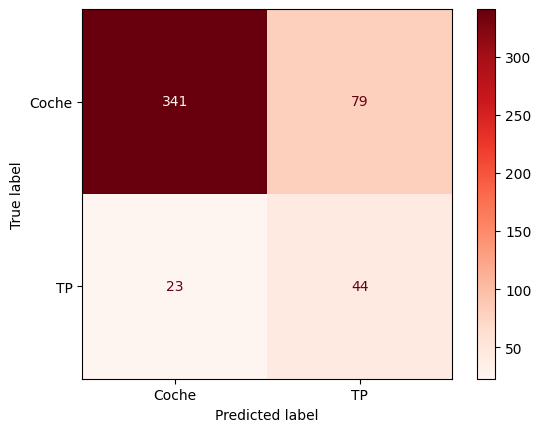

In [56]:
# Train-Test Split

# X = np.array(trips.drop(columns="Modo"))
# y = np.array( trips["Modo"] )
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train = np.array(trips_train.drop(columns="Modo"))
y_train = np.array(trips_train["Modo"])
X_test = np.array(trips_test.drop(columns="Modo"))
y_test = np.array(trips_test["Modo"])
# X_test = np.array(trips_train_p.drop(columns="Modo"))
# y_test = np.array(trips_train_p["Modo"])

# Model Training/Evaluation Framework

models = {}
# def train_evaluate(model,X=X,y=y,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,k=10,cross_validation=True):
def train_evaluate(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,k=10,cross_validation=False):

    model_name = type(model).__name__

    # El objetivo del cross-validation es evaluar el rendimiento del algoritmo de ML (rf in this case)
    # Pero no se usa luego para nada mas, el modelo que se entrena es otro, con otros datos

    # if cross_validation==True:
    #     print(model_name,"\n")
    #     print(f"{k}-FOLD CV\n")
    #     # k fold cross validation

    #     cv_scores = cross_val_score(model, X, y, cv=k,n_jobs=-1)

    #     # Scores on k-fold CV
    #     # Imprimir el score de cada ronda
    #     for i,score in zip(range(1,k+1),cv_scores):
    #         print(f"Round {i} score: {score}")
    #     print("")

    #     ax = sns.barplot(x = np.arange(1,11), y = np.array(cv_scores))
    #     ax.set(xlabel='Round', ylabel='Accuracy',title=f"{k}-fold CV Accuracy plot")
    #     plt.show()

    #     # scores avg on k-fold CV
    #     print(f"Score avg on {k}-fold CV: {cv_scores.mean()}\n")


    # Final Model
    print("\nFinal Model\n")
    # Model Training
    model = model.fit(X_train,y_train)
    print("Accuracy: ",model.score(X_test,y_test),"\n")
    # Prediction and Report
    y_pred = model.predict(X_test)
    print("Classification Report\n")
    print(metrics.classification_report(y_test, y_pred),"\n")

    print("Confusion Matrix\n")
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Reds")
    models[model_name] = model


    #pickle
    with open(os.path.join("models",f'{model_name}.pkl'), 'wb') as file:
        pkl.dump(model, file)

# Model Definiton and Evaluation

rf = RandomForestClassifier(n_estimators=20,random_state=random_state)
# rf = DecisionTreeClassifier(max_depth=5)
# rf = AdaBoostClassifier()
# rf = KNeighborsClassifier()
# rf = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),learning_rate=0.5, n_estimators=20,random_state=random_state)
train_evaluate(rf)

Elapsed time to compute the importances: 0.004 seconds


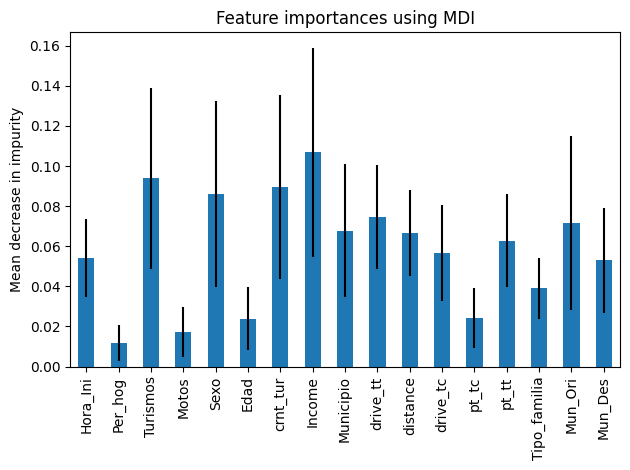

In [58]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
forest_importances = pd.Series(importances, index=trips_train.drop(columns='Modo').columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()